<a href="https://colab.research.google.com/github/BrystofKlazek/RAD/blob/main/01RAD_Ex09_endtaskfinished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01RAD Exercise 09

* Robust Regression - How to deal with Outliers and Leverages
* Very fast intro of Robust regression - M, MM, LTS, LWS


In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import seaborn as sns

import statsmodels.api as sm



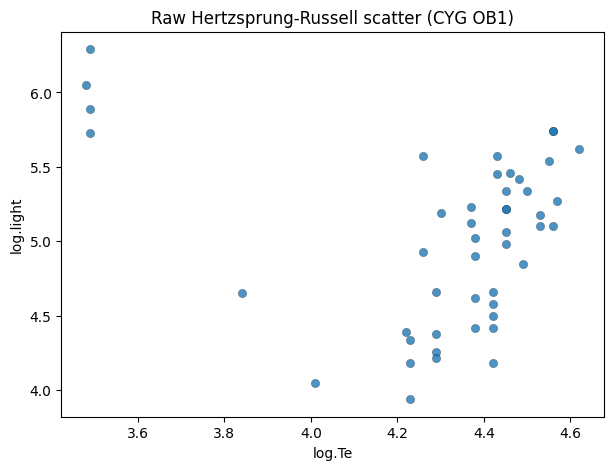

In [9]:

# Quick look at the Hertzsprung-Russell data to understand scale and pattern
# (x = surface temperature, y = luminous output)
dta = sm.datasets.get_rdataset("starsCYG", "robustbase", cache=True).data

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(dta['log.Te'], dta['log.light'], alpha=0.8, edgecolor='k', linewidth=0.2)
ax.set_xlabel('log.Te')
ax.set_ylabel('log.light')
ax.set_title('Raw Hertzsprung-Russell scatter (CYG OB1)')
plt.show()


In [10]:

# Fit baseline OLS to serve as the reference model for influence and robust comparisons
X = sm.add_constant(dta['log.Te'])  # Adding a constant for the intercept
y = dta['log.light']

OLS_stars = sm.OLS(y, X).fit()

print(OLS_stars.summary())


                            OLS Regression Results                            
Dep. Variable:              log.light   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.085
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.156
Time:                        20:02:04   Log-Likelihood:                -38.804
No. Observations:                  47   AIC:                             81.61
Df Residuals:                      45   BIC:                             85.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7935      1.237      5.494      0.0

In [11]:
def summarize_influence_measures_with_data(model, data):
    """
    Summarize influence measures, flag outliers, and include original data columns.

    :param model: Fitted regression model object from statsmodels.
    :param data: DataFrame used to fit the regression model.
    :return: DataFrame summarizing influence measures, flagged outliers, and original data.
    """
    influence = model.get_influence()

    # Extract measures
    leverage = influence.hat_matrix_diag
    cooks_distance = influence.cooks_distance[0]
    dffits = influence.dffits[0]
    dfbetas = influence.dfbetas
    cov_ratios = influence.cov_ratio

    # Number of observations and predictors
    n = int(model.nobs)
    p = int(model.df_model) + 1  # Add 1 to include the intercept

    # Rule of Thumb thresholds
    leverage_threshold = 2 * (p) / n
    cooks_distance_threshold = 4 / n
    dffits_threshold = 2 * np.sqrt((p) / n)
    dfbetas_threshold = 2 / np.sqrt(n)

    # Summarize outliers based on thresholds
    flagged = {
        'High Leverage': leverage > leverage_threshold,
        'High Cook\'s Distance': cooks_distance > cooks_distance_threshold,
        'High DFFITS': np.abs(dffits) > dffits_threshold,
    }

    # Flag observations with high DFBETAS for any predictor
    for j in range(dfbetas.shape[1]):
        flagged[f'High DFBETAS (Predictor {j})'] = np.abs(dfbetas[:, j]) > dfbetas_threshold

    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Leverage': leverage,
        'Cook\'s Distance': cooks_distance,
        'DFFITS': dffits,
        'Covariance Ratio': cov_ratios
    })

    # Add flags for rule-of-thumb violations
    for key, flag in flagged.items():
        summary_df[key] = flag

    # Combine summary DataFrame with original data
    summary_with_data = pd.concat([data.reset_index(drop=True), summary_df], axis=1)

    # Select rows where any flag is True
    flag_columns = [col for col in summary_df.columns if 'High' in col]
    flagged_observations = summary_with_data.loc[summary_df[flag_columns].any(axis=1)]

    return summary_with_data, flagged_observations


In [12]:
# Apply the function
all_observations_with_im, flagged_observations = summarize_influence_measures_with_data(OLS_stars, dta)

# Display the flagged observations
flagged_observations

,log.Te,log.light,Leverage,Cook's Distance,DFFITS,Covariance Ratio,High Leverage,High Cook's Distance,High DFFITS,High DFBETAS (Predictor 0),High DFBETAS (Predictor 1)
10,3.49,5.73,0.194103,0.067314,0.365093,1.265854,True,False,False,True,True
13,4.01,4.05,0.044409,0.089975,-0.438769,0.914313,False,True,True,True,True
19,3.49,5.89,0.194103,0.136155,0.522609,1.233499,True,True,True,True,True
29,3.48,6.05,0.198344,0.233691,0.690666,1.197519,True,True,True,True,True
33,3.49,6.29,0.194103,0.413249,0.935330,1.107499,True,True,True,True,True


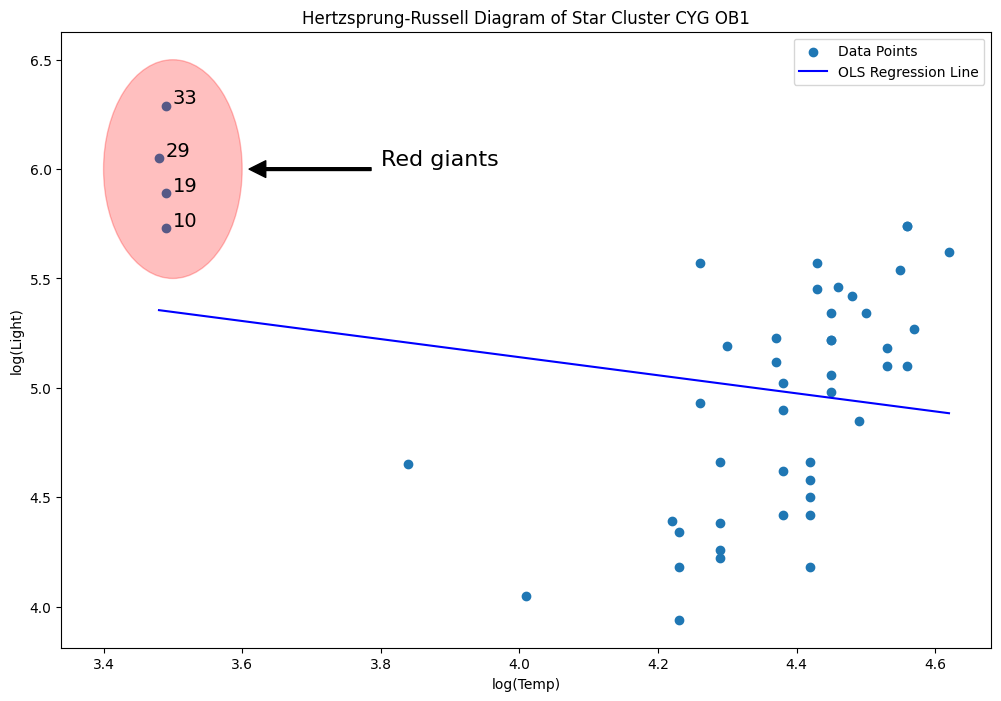

In [13]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    111,
    xlabel="log(Temp)",
    ylabel="log(Light)",
    title="Hertzsprung-Russell Diagram of Star Cluster CYG OB1",
)
ax.scatter(*dta.values.T, label='Data Points')

# Highlight outliers
e = Ellipse((3.5, 6), 0.2, 1, alpha=0.25, color="r")
ax.add_patch(e)
ax.annotate(
    "Red giants",
    xy=(3.6, 6),
    xytext=(3.8, 6),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
    horizontalalignment="left",
    verticalalignment="bottom",
    clip_on=True,  # Clip to the axes bounding box
    fontsize=16,
)

# Annotate observations with their index
for i, row in dta.loc[dta["log.Te"] < 3.8].iterrows():
    ax.annotate(i, row, row + 0.01, fontsize=14)

# Add the regression line from the OLS_stars model
# Generate x-values over the range of log.Te
x_vals = np.linspace(dta['log.Te'].min(), dta['log.Te'].max(), 100)
X_plot = sm.add_constant(x_vals)  # Add intercept term

# Predict y-values using the OLS model
y_vals = OLS_stars.predict(X_plot)

# Plot the regression line
ax.plot(x_vals, y_vals, color='blue', label='OLS Regression Line')

# Add legend
ax.legend()

# Show the plot
plt.show()


https://github.com/jseabold/statsmodels-tutorial/blob/master/robust_models.ipynb

https://github.com/statsmodels/statsmodels/blob/main/examples/notebooks/robust_models_0.ipynb

In [14]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(OLS_stars)
summary_influence = influence.summary_frame()

In [15]:
summary_influence.head()

,dfb_const,dfb_log.Te,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.008988,0.013249,0.002145,0.434638,0.022202,0.065493,0.430686,0.064898
1,-0.181126,0.196636,0.043661,1.500387,0.037341,0.295502,1.522185,0.299795
2,-0.006446,0.004667,0.000380,-0.184082,0.021919,-0.027557,-0.182093,-0.027260
3,-0.181126,0.196636,0.043661,1.500387,0.037341,0.295502,1.522185,0.299795
4,0.004598,-0.001578,0.001053,0.311035,0.021302,0.045888,0.307890,0.045424


In [16]:
# Number of observations and predictors
n = int(OLS_stars.nobs)
p = int(OLS_stars.df_model) + 1  # Include intercept

# Define thresholds
leverage_threshold = 2 * p / n
cooks_d_threshold = 4 / n
dffits_threshold = 2 * np.sqrt(p / n)
dfbetas_threshold = 2 / np.sqrt(n)


In [17]:
# Create a copy to avoid modifying the original DataFrame
influence_df = summary_influence.copy()

# Calculate flags for each measure
influence_df['High Leverage'] = influence_df['hat_diag'] > leverage_threshold
influence_df['High Cook\'s Distance'] = influence_df['cooks_d'] > cooks_d_threshold
influence_df['High DFFITS'] = np.abs(influence_df['dffits']) > dffits_threshold

# For DFBETAS, since there might be multiple predictors, check any of them
dfbetas_cols = [col for col in influence_df.columns if 'dfb_' in col]
influence_df['High DFBETAS'] = (np.abs(influence_df[dfbetas_cols]) > dfbetas_threshold).any(axis=1)

# Combine all flags into one
influence_df['Influential'] = (
    influence_df['High Leverage'] |
    influence_df['High Cook\'s Distance'] |
    influence_df['High DFFITS'] |
    influence_df['High DFBETAS']
)


In [18]:
# Get the indices of influential observations
influential_obs = influence_df[influence_df['Influential']]

# Display influential observations
influential_obs


,dfb_const,dfb_log.Te,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits,High Leverage,High Cook's Distance,High DFFITS,High DFBETAS,Influential
10,0.351789,-0.344502,0.067314,0.747639,0.194103,0.366918,0.743920,0.365093,True,False,False,True,True
13,-0.336199,0.316673,0.089975,-1.967779,0.044409,-0.424206,-2.035329,-0.438769,False,True,True,True,True
19,0.503564,-0.493135,0.136155,1.063296,0.194103,0.521833,1.064878,0.522609,True,True,True,True,True
29,0.666189,-0.652571,0.233691,1.374420,0.198344,0.683653,1.388520,0.690666,True,True,True,True,True
33,0.901246,-0.882580,0.413249,1.852438,0.194103,0.909119,1.905847,0.935330,True,True,True,True,True


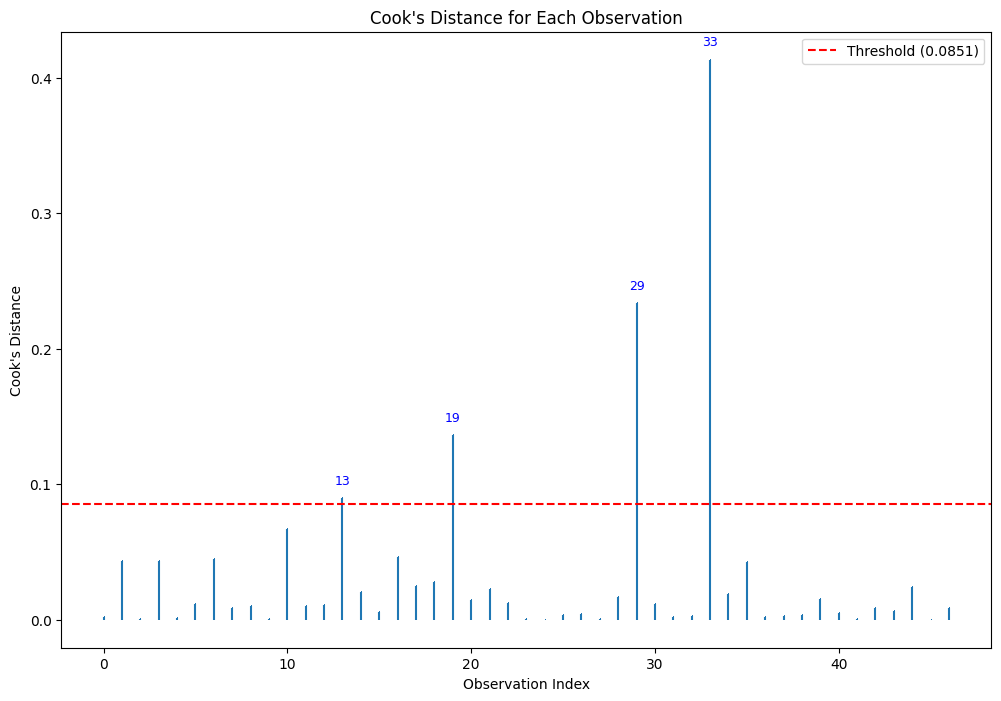

In [19]:
# Identify observations exceeding the threshold
cooks_d = summary_influence['cooks_d']
influential_obs = cooks_d > cooks_d_threshold
influential_indices = summary_influence[influential_obs].index

# Create the stem plot of Cook's Distance
plt.figure(figsize=(12, 8))
markerline, stemlines, baseline = plt.stem(
    summary_influence.index, cooks_d, markerfmt=",", basefmt=" "
)
plt.axhline(y=cooks_d_threshold, color='red', linestyle='--', label=f'Threshold ({cooks_d_threshold:.4f})')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Observation")
plt.legend()

# Annotate influential observations
for idx in influential_indices:
    plt.annotate(
        str(idx),
        (idx, cooks_d[idx]),
        textcoords="offset points",
        xytext=(0, 10),  # Offset label above the point
        ha='center',
        fontsize=9,
        color='blue'
    )

plt.show()


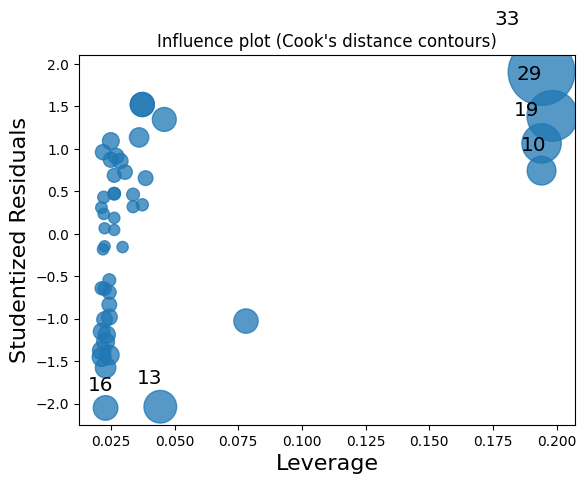

In [20]:

# Visual diagnostic: Cook's distance bubble plot; points outside dashed contours are influential.
from statsmodels.graphics.regressionplots import influence_plot

influence_plot(OLS_stars, criterion="cooks")
plt.title("Influence plot")
plt.show()


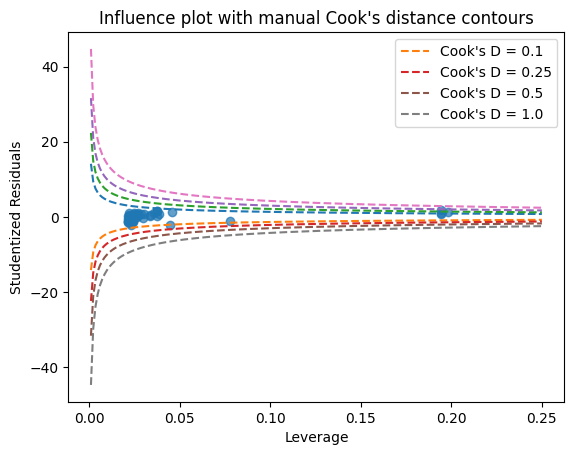

In [42]:

res = OLS_stars
infl = res.get_influence()

leverage = infl.hat_matrix_diag
stud_resid = infl.resid_studentized_external

# number of parameters (including intercept)
p = int(res.df_model) + 1

plt.figure()
plt.scatter(leverage, stud_resid, alpha=0.7)

h_grid = np.linspace(0.001, max(0.25, leverage.max()*1.1), 200)
for D in [0.1, 0.25, 0.5, 1.0]:
    r = np.sqrt(D * p * (1 - h_grid) / h_grid)
    plt.plot(h_grid,  r, linestyle="--")
    plt.plot(h_grid, -r, linestyle="--", label=f"Cook's D = {D}")

plt.xlabel("Leverage")
plt.ylabel("Studentized Residuals")
plt.title("Influence plot with manual Cook's distance contours")
plt.legend()
plt.show()


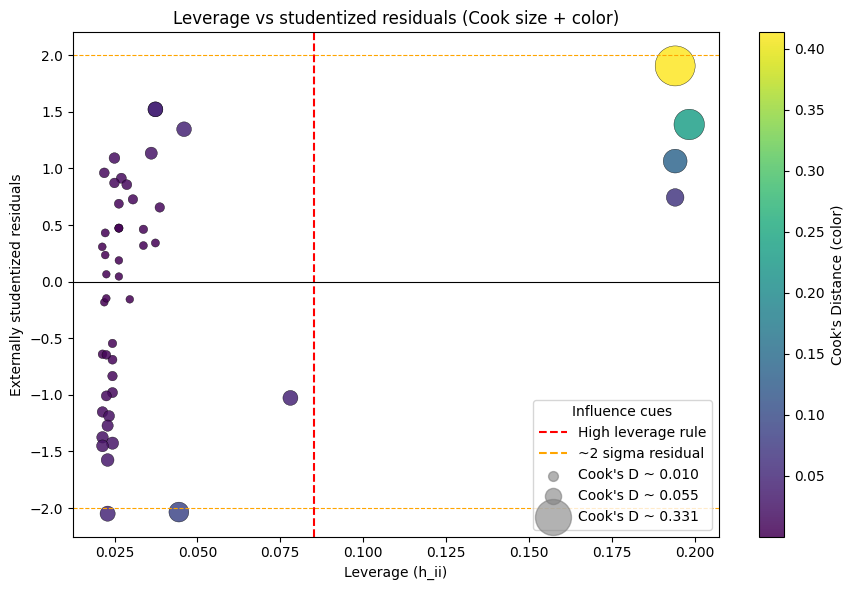

In [21]:

# Leverage vs externally studentized residuals with Cook's distance encoded by color and size
influence = OLS_stars.get_influence()
leverage_vals = influence.hat_matrix_diag
student_resid_ext = influence.resid_studentized_external
cooks = influence.cooks_distance[0]

size_factor = 800 / (cooks.max() + 1e-6)  # scale markers without blowing up tiny distances
scaled_sizes = size_factor * cooks + 30  # minimal size keeps non-influential points visible

plt.figure(figsize=(9, 6))
scatter = plt.scatter(
    leverage_vals,
    student_resid_ext,
    c=cooks,
    s=scaled_sizes,
    cmap='viridis',
    alpha=0.85,
    edgecolor='k',
    linewidth=0.3,
)
plt.colorbar(scatter, label="Cook's Distance (color)")

p = len(OLS_stars.params)
n = int(OLS_stars.nobs)
leverage_threshold = 2 * p / n
plt.axvline(leverage_threshold, color='red', linestyle='--', label='High leverage rule')
plt.axhline(0, color='black', linewidth=0.8)
plt.axhline(2, color='orange', linestyle='--', linewidth=0.8, label='~2 sigma residual')
plt.axhline(-2, color='orange', linestyle='--', linewidth=0.8)
plt.xlabel('Leverage (h_ii)')
plt.ylabel('Externally studentized residuals')
plt.title('Leverage vs studentized residuals (Cook size + color)')

# Legend explaining size encoding alongside threshold lines
size_examples = [np.percentile(cooks, q) for q in (50, 90, 99)]
size_handles = [
    plt.scatter([], [], s=size_factor * s + 30, color='gray', alpha=0.6, label=f"Cook's D ~ {s:.3f}")
    for s in size_examples
]
line_handles = [
    plt.Line2D([], [], color='red', linestyle='--', label='High leverage rule'),
    plt.Line2D([], [], color='orange', linestyle='--', label='~2 sigma residual'),
]
plt.legend(handles=line_handles + size_handles, title='Influence cues', loc='lower right', frameon=True)

plt.tight_layout()
plt.show()


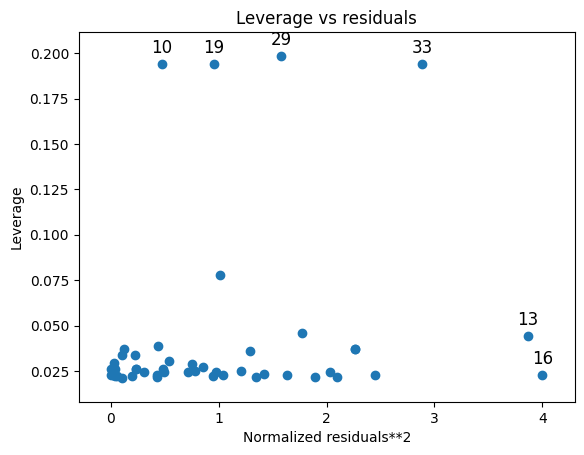

In [22]:

# Quick helper from statsmodels that overlays leverage vs residuals
from statsmodels.graphics.regressionplots import plot_leverage_resid2

plot_leverage_resid2(OLS_stars)
plt.title('Leverage vs residuals')
plt.show()


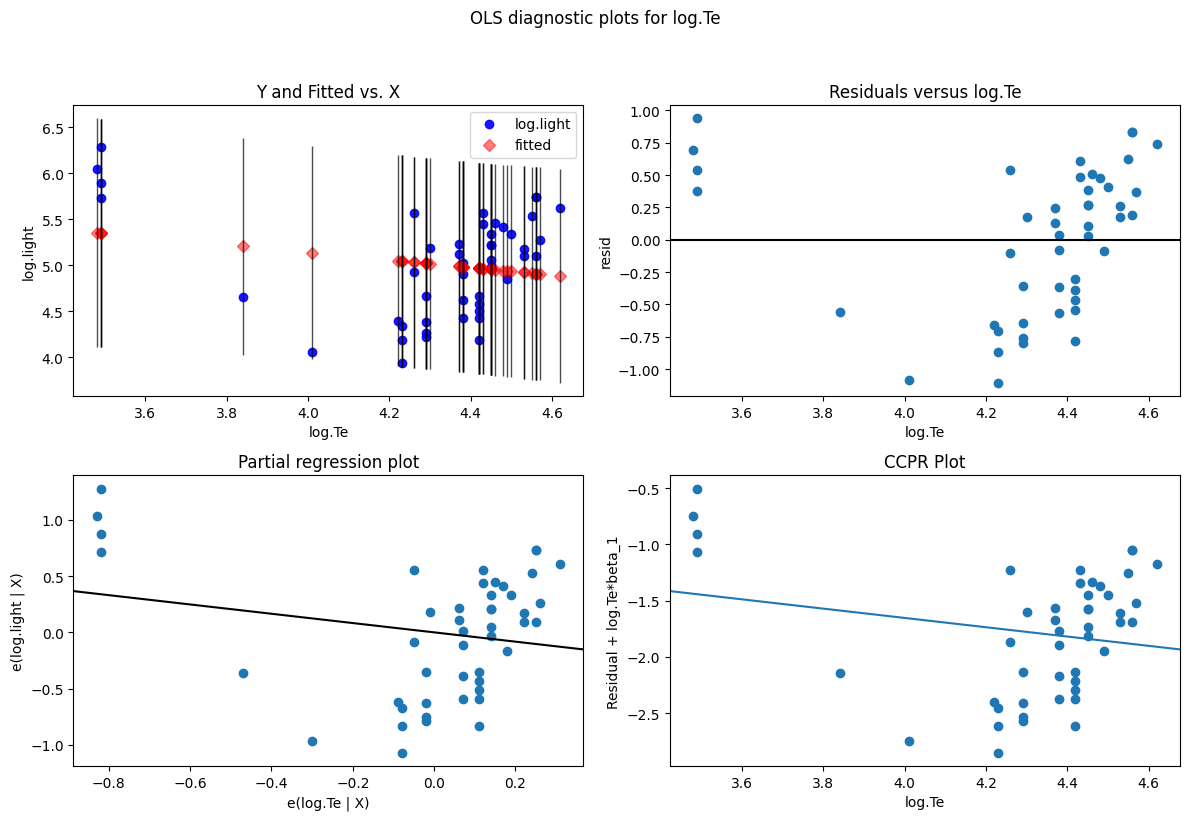

In [23]:

# Regression diagnostics for the predictor log.Te (fits, partial regression, residuals, leverage)
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(OLS_stars, 'log.Te', fig=fig)
plt.suptitle('OLS diagnostic plots for log.Te', y=1.02)
plt.show()


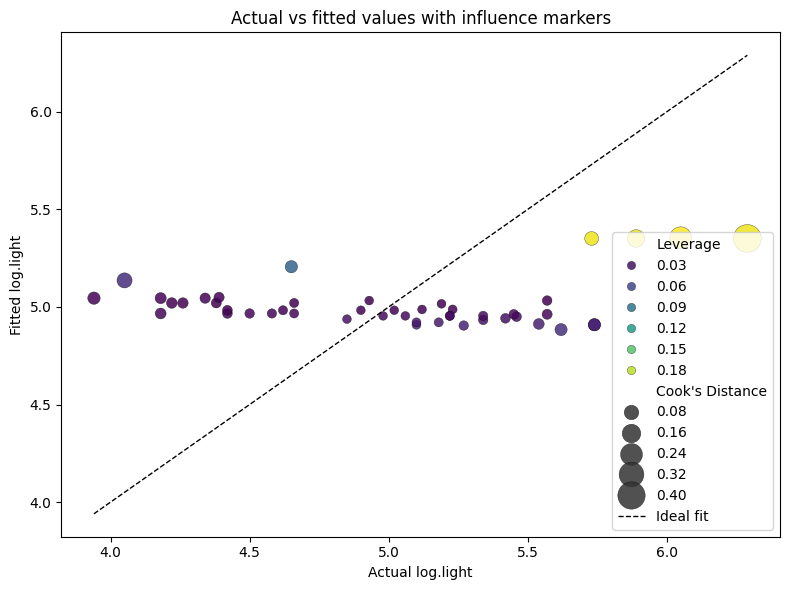

In [24]:

# Additional diagnostic: actual vs fitted values colored by leverage and sized by Cook's distance
influence = OLS_stars.get_influence()
plot_df = pd.DataFrame({
    "Actual log.light": y,
    "Fitted log.light": OLS_stars.fittedvalues,
    "Cook's Distance": influence.cooks_distance[0],
    "Leverage": influence.hat_matrix_diag,
})

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=plot_df,
    x='Actual log.light',
    y='Fitted log.light',
    hue='Leverage',
    size="Cook's Distance",
    palette='viridis',
    sizes=(40, 400),
    alpha=0.85,
    edgecolor='k',
    linewidth=0.25,
)
min_val = plot_df[['Actual log.light', 'Fitted log.light']].min().min()
max_val = plot_df[['Actual log.light', 'Fitted log.light']].max().max()
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1, label='Ideal fit')
ax.set_title('Actual vs fitted values with influence markers')
ax.legend(loc='best', title=None)
plt.tight_layout()
plt.show()


## Robust Regression


### Robust regression: M, LTS and LMS

The classical linear model minimizes the sum of squared residuals
$\sum_i r_i^2$, which is very sensitive to outliers and high-leverage points.
Robust regression modifies the objective so that extreme residuals have
bounded influence.

- **M-estimators** choose $\hat\beta$ by minimizing a *robust loss*
  $\sum_i \rho(r_i / \sigma)$. The derivative
  $\psi(r) = \rho'(r)$ defines the influence of each residual and the
  *weights* are $w_i = \psi(r_i/\sigma)/(r_i/\sigma)$. Large residuals
  get down-weighted.
- **LTS (Least Trimmed Squares)** minimizes a *trimmed* sum of squares
  $\sum_{i=1}^h r_{(i)}^2$, where $r_{(1)}^2 \le \dots \le r_{(n)}^2$
  are the ordered squared residuals and $h = \lceil \alpha n \rceil$.
  Only the $h$ observations with the smallest residuals influence the
  fit, giving high breakdown against outliers.
- **LMS (Least Median of Squares)** minimizes the median of squared
  residuals $\operatorname{med}_i\, r_i^2$. This has even higher
  robustness but lower efficiency and is often used as a starting point
  for more efficient MM-type procedures.



### M-estimators, $\rho$, $\psi$ and weights

For a regression model $y_i = x_i^\top \beta + \varepsilon_i$ the
residuals are $r_i = y_i - x_i^\top \beta$. An M-estimator chooses
$\hat\beta$ as a solution of
$$
\sum_{i=1}^n \psi\!\left(\frac{r_i}{\sigma}\right) x_i = 0,
$$
which is equivalent to minimizing
$\sum_i \rho(r_i/\sigma)$ with $\psi = \rho'$.

- $\rho$ controls how quickly large residuals stop contributing to the
  objective.
- $\psi$ is the *influence function*; bounded $\psi$ implies bounded
  influence of any single observation.
- The implied *weights* are
  $$
  w_i = \frac{\psi(r_i/\sigma)}{r_i/\sigma},
  $$
  so the IRLS algorithm fits a sequence of weighted least-squares
  problems where down-weighted points ($|r_i|$ large) have less impact.

  

Below we visualize $\rho$, $\psi$ and the weights for several
standard robust functions.


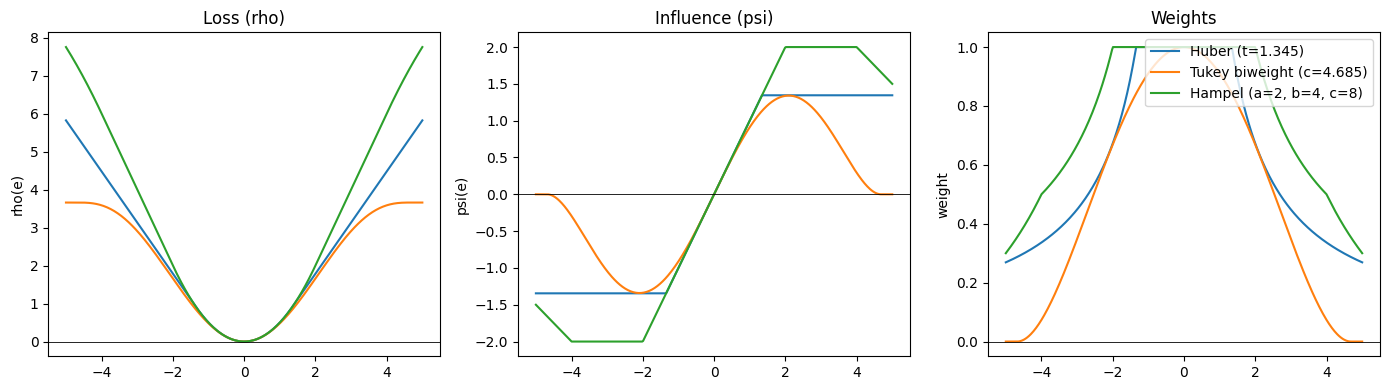

In [25]:

# Compare rho, psi, and weights for common M-estimators
from statsmodels.robust import norms

x_vals = np.linspace(-5, 5, 400)
choices = {
    'Huber (t=1.345)': norms.HuberT(t=1.345),
    'Tukey biweight (c=4.685)': norms.TukeyBiweight(c=4.685),
    'Hampel (a=2, b=4, c=8)': norms.Hampel(a=2.0, b=4.0, c=8.0),
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
for label, norm in choices.items():
    axes[0].plot(x_vals, norm.rho(x_vals), label=label)
    axes[1].plot(x_vals, norm.psi(x_vals), label=label)
    axes[2].plot(x_vals, norm.weights(x_vals), label=label)
axes[0].set_ylabel('rho(e)')
axes[1].set_ylabel('psi(e)')
axes[2].set_ylabel('weight')
for ax, title in zip(axes, ['Loss (rho)', 'Influence (psi)', 'Weights']):
    ax.axhline(0, color='black', linewidth=0.6)
    ax.set_title(title)
axes[2].legend(loc='upper right')
plt.tight_layout()
plt.show()


https://cran.r-project.org/web/packages/robustbase/vignettes/psi_functions.pdf


#### Examples of $\rho$, $\psi$ and weights

Let $u = r/\sigma$ be the standardized residual.

- **Huber function (tuning constant $k$)**
  $$
  \rho_H(u) =
  \begin{cases}
  \tfrac{1}{2}u^2, & |u| \le k,\\[2pt]
  k|u| - \tfrac{1}{2}k^2, & |u| > k,
  \end{cases}
  $$
  $$
  \psi_H(u) =
  \begin{cases}
  u, & |u| \le k,\\[2pt]
  k\,\operatorname{sign}(u), & |u| > k,
  \end{cases}
  $$
  $$
  w_H(u) = \frac{\psi_H(u)}{u} =
  \begin{cases}
  1, & |u| \le k,\\[2pt]
  k/|u|, & |u| > k.
  \end{cases}
  $$

- **Tukey biweight (bisquare, tuning constant $c$)**
  $$
  \rho_T(u) =
  \begin{cases}
  \tfrac{c^2}{6}\bigl[1 - (1 - (u/c)^2)^3\bigr], & |u| \le c,\\[2pt]
  \tfrac{c^2}{6}, & |u| > c,
  \end{cases}
  $$

  $$
  \psi_T(u) =
  \begin{cases}
  u\bigl(1 - (u/c)^2\bigr)^2, & |u| \le c,\\[2pt]
  0, & |u| > c,
  \end{cases}
  $$
  $$
  w_T(u) =
  \begin{cases}
  \bigl(1 - (u/c)^2\bigr)^2, & |u| \le c,\\[2pt]
  0, & |u| > c.
  \end{cases}
  $$

- **Andrews sine (tuning constant $c$)**
  $$
  \psi_A(u) =
  \begin{cases}
  \sin(u/c), & |u| < \pi c,\\[2pt]
  0, & |u| \ge \pi c,
  \end{cases}
  $$
  and $\rho_A(u)$ is its integral, bounded and periodic. The
  corresponding weights are $w_A(u) = \psi_A(u)/u$, giving high weight
  near zero and smoothly down-weighting large residuals up to the cutoff
  $\pi c$.

These functions trade off robustness (how aggressively large residuals
are down-weighted) against efficiency under a pure Gaussian model.



**GM/MM estimators**
- **GM** combines an M-estimator for location with high-breakdown leverage handling (e.g., bounded influence functions for both residuals and leverage). It guards against leverage points plus outliers.
- **MM** starts from a high-breakdown S- or LMS/LTS-estimate (for robustness) and refines with an efficient M-step (for efficiency at the Gaussian model). In Python we approximate MM via a strong Tukey/Huber fit after a trimmed start.


In [26]:
# Load the CYG OB1 star cluster data (robustbase::starsCYG equivalent) via statsmodels
import statsmodels.api as sm
stars_cyg = sm.datasets.get_rdataset("starsCYG", "robustbase", cache=True).data
stars_cyg.describe(include='all')

,log.Te,log.light
count,47.000000,47.000000
mean,4.310000,5.012128
std,0.290823,0.571249
min,3.480000,3.940000
25%,4.275000,4.540000
50%,4.420000,5.100000
75%,4.455000,5.435000
max,4.620000,6.290000


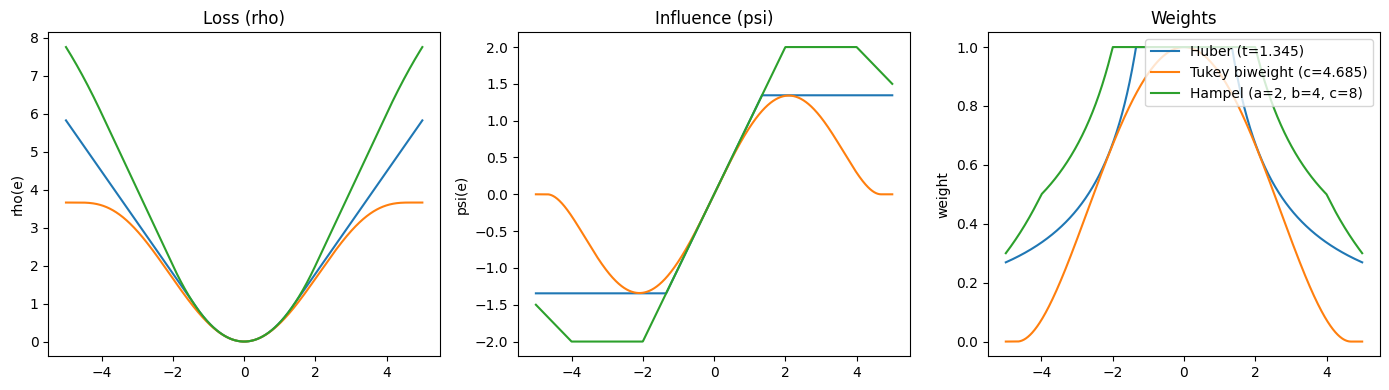

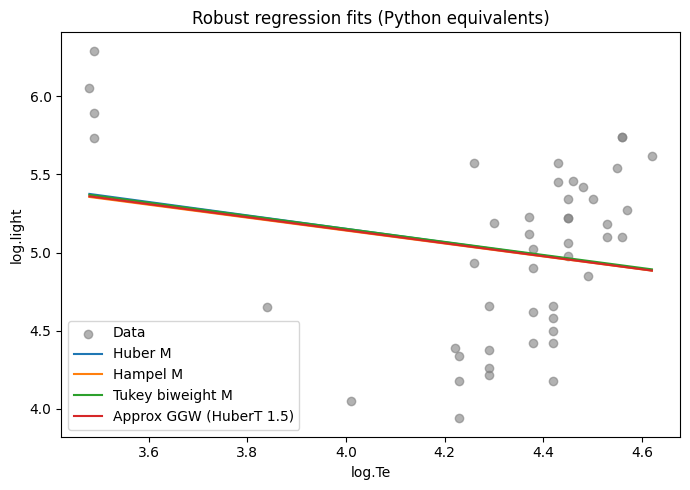

In [27]:

# Robust regression and psi-function shapes
from statsmodels.robust import norms

x_vals = np.linspace(-5, 5, 1000)

# Define psi (influence) functions and their rho/weights
huber = norms.HuberT(t=1.345)
tukey = norms.TukeyBiweight(c=4.685)
hampel = norms.Hampel(a=2.0, b=4.0, c=8.0)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
for label, norm in {
    'Huber (t=1.345)': huber,
    'Tukey biweight (c=4.685)': tukey,
    'Hampel (a=2, b=4, c=8)': hampel,
}.items():
    axes[0].plot(x_vals, norm.rho(x_vals), label=label)
    axes[1].plot(x_vals, norm.psi(x_vals), label=label)
    axes[2].plot(x_vals, norm.weights(x_vals), label=label)
axes[0].set_title('Loss (rho)')
axes[1].set_title('Influence (psi)')
axes[2].set_title('Weights')
axes[0].set_ylabel('rho(e)')
axes[1].set_ylabel('psi(e)')
axes[2].set_ylabel('weight')
axes[2].legend(loc='upper right')
plt.tight_layout()
plt.show()

# Fit robust models analogous to the R variants
X_stars = sm.add_constant(dta['log.Te'])
y_stars = dta['log.light']
robust_models = {
    'Huber M': sm.RLM(y_stars, X_stars, M=huber).fit(),
    'Hampel M': sm.RLM(y_stars, X_stars, M=hampel).fit(),
    'Tukey biweight M': sm.RLM(y_stars, X_stars, M=tukey).fit(),
}
# Statsmodels lacks a direct GGW/MM implementation; reuse a stronger HuberT as a loose proxy.
robust_models['Approx GGW (HuberT 1.5)'] = sm.RLM(y_stars, X_stars, M=norms.HuberT(t=1.5)).fit()

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(dta['log.Te'], dta['log.light'], color='gray', alpha=0.6, label='Data')
x_grid = np.linspace(dta['log.Te'].min(), dta['log.Te'].max(), 200)
X_grid = sm.add_constant(x_grid)
for name, model in robust_models.items():
    ax.plot(x_grid, model.predict(X_grid), label=name)
ax.set_xlabel('log.Te')
ax.set_ylabel('log.light')
ax.set_title('Robust regression fits (Python equivalents)')
ax.legend()
plt.tight_layout()
plt.show()


In [28]:
# Robust regression using statsmodels' RLM

# Huber's T
huber_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.HuberT())
M_huber_stars = huber_model.fit()

# Hampel
hampel_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.Hampel())
M_hampel_stars = hampel_model.fit()

# Bisquare (Tukey's biweight)
bisquare_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.TukeyBiweight())
M_bisquare_stars = bisquare_model.fit()



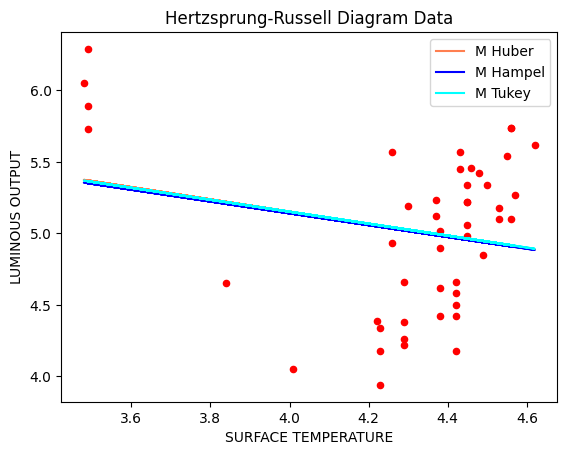

In [29]:
# Plotting the Hertzsprung-Russell Diagram Data with regression lines
plt.scatter(dta['log.Te'], dta['log.light'], color='red', s=20)
plt.xlabel('SURFACE TEMPERATURE')
plt.ylabel('LUMINOUS OUTPUT')
plt.title('Hertzsprung-Russell Diagram Data')

# Adding regression lines
plt.plot(dta['log.Te'], M_huber_stars.fittedvalues, color='coral', label='M Huber')
plt.plot(dta['log.Te'], M_hampel_stars.fittedvalues, color='blue', label='M Hampel')
plt.plot(dta['log.Te'], M_bisquare_stars.fittedvalues, color='cyan', label='M Tukey')


plt.legend()
plt.show()


In [30]:

# Coefficient comparison across the robust fits from the Python equivalents
import pandas as pd
coef_df = pd.DataFrame({name: model.params for name, model in robust_models.items()}).T
coef_df


,const,log.Te
Huber M,6.865887,-0.428523
Hampel M,6.793467,-0.413304
Tukey biweight M,6.823507,-0.417980
Approx GGW (HuberT 1.5),6.808284,-0.416378


In [31]:

# Approximate lmrob-style MM estimate using available Python tools
try:
    from sklearn.linear_model import HuberRegressor
    huber_reg = HuberRegressor().fit(dta[['log.Te']], dta['log.light'])
    print('sklearn HuberRegressor coefficients (approx MM):')
    print({'intercept': huber_reg.intercept_, 'log.Te': huber_reg.coef_[0]})
except Exception as exc:
    print('sklearn not available or failed:', exc)
    print('Fallback to statsmodels Tukey biweight RLM (proxy for lmrob):')
    print(robust_models['Tukey biweight M'].params)


sklearn HuberRegressor coefficients (approx MM):
{'intercept': np.float64(6.930995597629528), 'log.Te': np.float64(-0.43873417477616433)}



### LTS and LMS estimators
- **Least Trimmed Squares (LTS)** keeps only the `h = ceil(alpha * n)` observations with the smallest residuals and minimizes the trimmed sum of squared residuals; it has high breakdown at the cost of efficiency.
- **Least Median of Squares (LMS)** minimizes the median of squared residuals, offering even higher breakdown but lower efficiency; both methods are useful starting points for MM estimators.
- The helper `least_trimmed_squares` below implements a simple iterative LTS approximation for the one-predictor and multi-predictor cases.


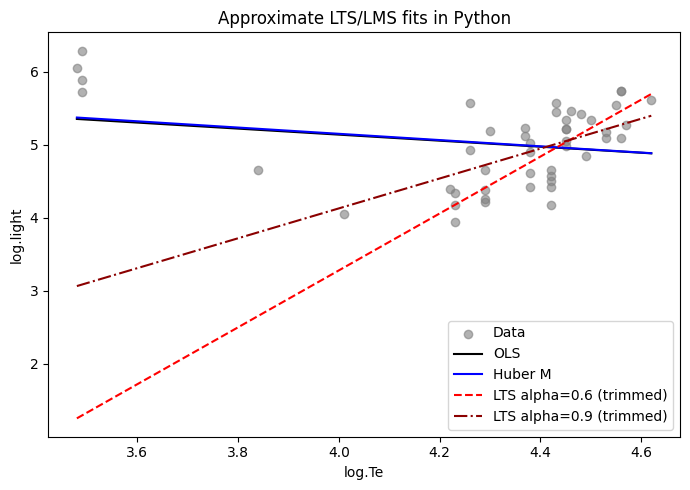

In [32]:
# LTS/LMS-style robust fits using a trimmed least squares approximation

import numpy as np
import statsmodels.api as sm


def least_trimmed_squares(x, y, alpha=0.9, max_iter=1000, tol=1e-6, n_starts=100):
    """Least Trimmed Squares via C-steps with multiple random starts.

    Parameters
    ----------
    x : array-like or DataFrame
        Predictor(s). A constant will be added internally.
    y : array-like
        Response vector of length n.
    alpha : float, optional
        Trimming proportion in (0, 1). h = ceil(alpha * n) observations are kept.
    max_iter : int, optional
        Maximum number of C-steps for each random start.
    tol : float, optional
        Convergence tolerance on the parameter vector (L2 norm).
    n_starts : int, optional
        Number of random (p+1)-subsets used as starting values.

    Returns
    -------
    params : ndarray, shape (p+1,)
        Estimated regression coefficients (including intercept).
    keep_idx : ndarray
        Indices of the h observations with smallest residuals for the best solution.
    """
    y_arr = np.asarray(y).ravel()
    X = np.asarray(x)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    X_design = sm.add_constant(X)

    n, p1 = X_design.shape  # p1 = p + 1 (includes intercept)
    h = int(np.ceil(alpha * n))
    if h <= p1:
        raise ValueError("alpha too small: h must be > number of parameters")

    best_obj = np.inf
    best_params = None
    best_keep = None

    rng = np.random.default_rng()

    for _ in range(n_starts):
        subset_idx = rng.choice(n, size=p1, replace=False)
        try:
            beta = np.linalg.lstsq(X_design[subset_idx], y_arr[subset_idx], rcond=None)[0]
        except np.linalg.LinAlgError:
            continue

        for _ in range(max_iter):
            residuals = y_arr - X_design @ beta
            order = np.argsort(residuals ** 2)
            keep = order[:h]
            X_h = X_design[keep]
            y_h = y_arr[keep]
            try:
                beta_new = np.linalg.lstsq(X_h, y_h, rcond=None)[0]
            except np.linalg.LinAlgError:
                break
            if np.linalg.norm(beta_new - beta) < tol:
                beta = beta_new
                break
            beta = beta_new

        residuals = y_arr - X_design @ beta
        order = np.argsort(residuals ** 2)
        keep = order[:h]
        obj = np.sum(residuals[keep] ** 2)
        if obj < best_obj:
            best_obj = obj
            best_params = beta
            best_keep = keep

    if best_params is None:
        best_params = sm.OLS(y_arr, X_design).fit().params
        best_keep = np.arange(n)

    return best_params, best_keep


lts_params_60, keep60 = least_trimmed_squares(dta['log.Te'], dta['log.light'], alpha=0.6, max_iter=1000, tol=1e-6, n_starts=100)
lts_params_90, keep90 = least_trimmed_squares(dta['log.Te'], dta['log.light'], alpha=0.9, max_iter=1000, tol=1e-6, n_starts=100)

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(dta['log.Te'], dta['log.light'], color='gray', alpha=0.6, label='Data')
ax.plot(x_grid, sm.OLS(y_stars, X_stars).fit().predict(X_grid), color='black', label='OLS')
ax.plot(x_grid, robust_models['Huber M'].predict(X_grid), color='blue', label='Huber M')
ax.plot(x_grid, X_grid @ lts_params_60, color='red', linestyle='--', label='LTS alpha=0.6 (trimmed)')
ax.plot(x_grid, X_grid @ lts_params_90, color='darkred', linestyle='-.', label='LTS alpha=0.9 (trimmed)')
ax.set_xlabel('log.Te')
ax.set_ylabel('log.light')
ax.set_title('Approximate LTS/LMS fits in Python')
ax.legend()
plt.tight_layout()
plt.show()



### Degenerate / nongeneral position designs

A design is in **general position** when no small subset of points lies
on an almost perfect lower dimensional subspace (for example, many
points sharing the same $x$ value or nearly exact collinearity). When
this condition fails:

- Some observations have extremely high leverage, so small changes in
  their $y$ values can move the OLS fit dramatically.
- The X'X matrix becomes nearly singular, making standard errors and
  diagnostics unstable.
- Classical high breakdown methods like LMS/LTS can fail to find a
  unique solution unless additional precautions are taken.




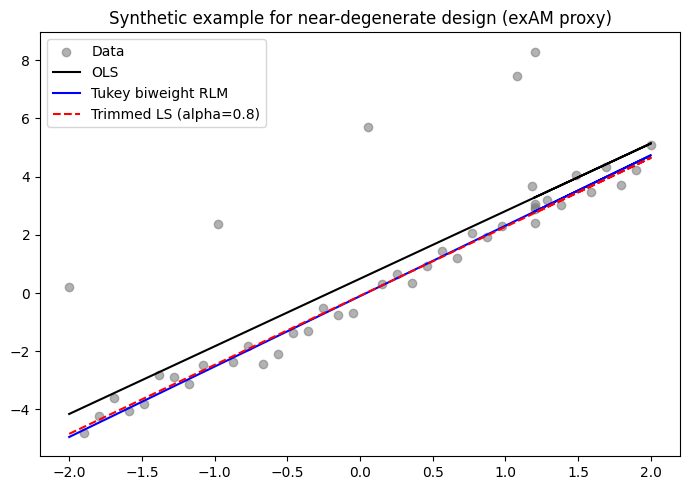

In [33]:

# The robustbase exAM dataset is not available in Python; simulate a near-degenerate design instead
np.random.seed(42)
x_sim = np.r_[np.linspace(-2, 2, 40), np.ones(5) * 1.2]  # repeated values break general position
noise = np.random.normal(scale=0.4, size=x_sim.size)
y_sim = 2.5 * x_sim + noise
# Add a few large outliers
y_sim[::10] += 5

X_sim = sm.add_constant(x_sim)
ols_sim = sm.OLS(y_sim, X_sim).fit()
robust_sim = sm.RLM(y_sim, X_sim, M=norms.TukeyBiweight()).fit()
lts_sim_params, keep_sim = least_trimmed_squares(x_sim, y_sim, alpha=0.8, max_iter=20)

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x_sim, y_sim, color='gray', alpha=0.6, label='Data')
ax.plot(x_sim, ols_sim.predict(X_sim), color='black', label='OLS')
ax.plot(x_sim, robust_sim.predict(X_sim), color='blue', label='Tukey biweight RLM')
ax.plot(x_sim, X_sim @ lts_sim_params, color='red', linestyle='--', label='Trimmed LS (alpha=0.8)')
ax.set_title('Synthetic example for near-degenerate design (exAM proxy)')
ax.legend()
plt.tight_layout()
plt.show()


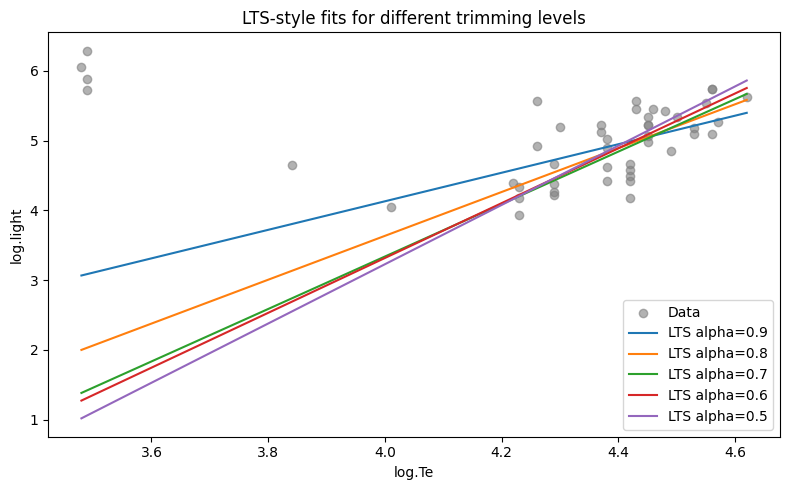

,intercept,log.Te
0.9,-4.056524,2.046657
0.8,-8.948738,3.145737
0.7,-11.712087,3.762468
0.6,-12.415166,3.932983
0.5,-13.775743,4.250736


In [34]:

# Explore how the trimming fraction alpha affects LTS-style fits on the stars data
alphas = [0.9, 0.8, 0.7, 0.6, 0.5]
lts_lines = {}
for a in alphas:
    params, keep_idx = least_trimmed_squares(dta['log.Te'], dta['log.light'], alpha=a, max_iter=20)
    lts_lines[a] = params

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(dta['log.Te'], dta['log.light'], color='gray', alpha=0.6, label='Data')
for a, params in lts_lines.items():
    ax.plot(x_grid, X_grid @ params, label=f'LTS alpha={a}')
ax.set_xlabel('log.Te')
ax.set_ylabel('log.light')
ax.set_title('LTS-style fits for different trimming levels')
ax.legend()
plt.tight_layout()
plt.show()

pd.DataFrame(lts_lines).T.rename(columns={0: 'intercept', 1: 'log.Te'})


In [38]:

# Python translation of the LWS helper functions

def weights1(n):
    # Replicate the R Weights1: flat weights then taper to zero.
    h = int(np.ceil(0.9 * n))
    g = int(np.ceil(0.8 * n))
    w = np.zeros(n)
    w[:g] = 1
    if h > g:
        w[g:h] = np.linspace(1, 0, num=h - g)
    return w

def ols_qr(y, X, tol=1e-7):
    return np.linalg.lstsq(X, y, rcond=tol)[0]

def lws_one_iter(Y, X, w, tau=1e-5):
    n, p = X.shape
    b_one = np.zeros(p)
    # Select stable starting subset
    while True:
        idx = np.random.permutation(n)
        subset = X[idx[: p + 2], :]
        if np.linalg.cond(subset) < 1e9:
            break
    b = ols_qr(Y[idx[: p + 2]], subset)
    while not np.all(np.abs(b_one - b) < tau):
        b_one = b
        r = (Y - X @ b) ** 2
        r_order = np.argsort(r)
        sX = X[r_order, :]
        sY = Y[r_order]
        mask = w != 0
        swX = (np.sqrt(w)[:, None] * sX)[mask]
        swY = (np.sqrt(w) * sY)[mask]
        b = ols_qr(swY, swX)
    r_one = (Y - X @ b_one) ** 2
    perm_one = np.argsort(r_one)
    rWr_one = (r_one[perm_one] ** 2) @ w
    return {"b": b_one, "rWr": float(rWr_one), "perm": perm_one}

def lws(Y, X, w, niter=100):
    # Least Weighted Squares search limited to niter iterations.
    best = {"rWr": np.inf, "b": None, "perm": None}
    for _ in range(niter):
        one = lws_one_iter(Y, X, w)
        if one["rWr"] < best["rWr"]:
            best = one
    return best


# Task 01: Regression Analysis Experimentation

### 1. Compare LWS with Other Methods
- Utilize the **Locally Weighted Scatterplot Smoothing (LWS)**  -- What? I thought that would be something completly different than the Least Weighted Squares??? We just have the Least weighted squares. method on the dataset from the previous lesson.
- Compare the results of LWS with other regression methods (e.g., OLS or LTS).
- Experiment by varying the input parameters of the LWS method to observe changes in performance and results.

### 2. Implement Custom Weight Function for LWS
- Create a function `Weights2` to generate weights for the LWS method:
  - For the first `g` observations, the weights should decrease linearly such that over the interval `(0, g)` the weight reduces by 0.1.
  - Over the interval `(g, h)`, the weights should decrease from 0.9 to 0.
  - For the remaining `(n-h)` observations, the weights should be zero (i.e., weights are null over `(h, n)`).
  - Parameters `g` and `h` should be inputs to this function.

### 3. Experiment: Consistency of Regression Parameter Estimation
- Conduct experiments to test the consistency of regression parameter estimates using LWS.
- Generate data for different numbers of observations: `50, 100, 200, 300, 400, 500`.
- Structure the design matrix `X` with the following columns:
  1. Intercept term (constant).
  2. Binomially distributed observations (`k=10`, `p=0.3`) shifted by +1.
  3. Normally distributed observations with `N(10, 2)`.
  4. Normally distributed observations with `N(20, 3)`.
  5. Exponentially distributed observations with a mean of 8.
- Use a regression coefficient vector: `beta0 = [2, 3, -2, 2, 3]`.

### 4. Evaluate and Visualize Results
- For each specified number of observations, generate 1000 datasets.
- Compute parameter estimates using **OLS**, **LWS**, and **LTS** methods.
- Calculate:
  - The empirical **median of the standard error (SE)** or the **mean squared error (MSE)** for each parameter estimate.
- Plot the dependence of the median (or eMSE) on the number of observations for all three methods.

### 5. Handle Outliers
- Repeat the experiment with:
  - **0%**, **5%**, and **10% outliers** in the dataset.
- Design outliers based on your assumptions or domain-specific logic.


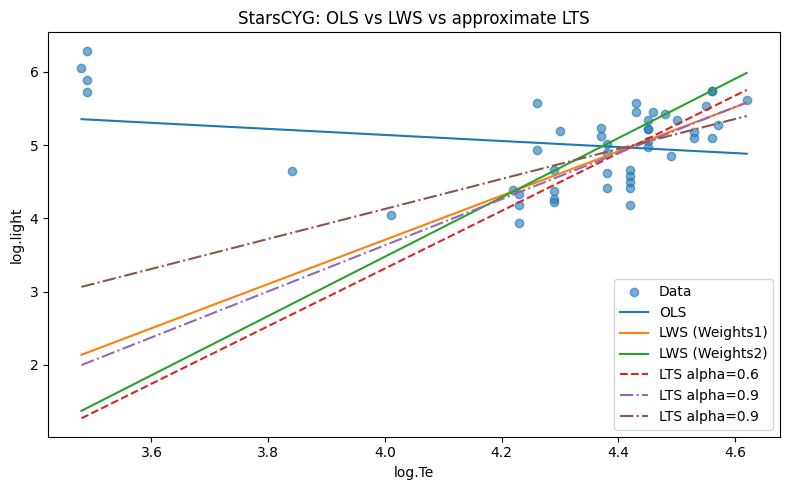

In [53]:


def Weights2(n, g, h):

    w = np.zeros(n, dtype=float)

    if g == 1:
        w[0] = 1.0
    else:
        w[:g] = np.linspace(1.0, 0.9, num=g)

    if h - g == 1:
        w[g] = 0.9
    else:
        w[g:h] = np.linspace(0.9, 0.0, num=h - g)

    return w


# Loading the dataset
x_stars = np.asarray(dta['log.Te'])
y_stars = np.asarray(dta['log.light'])
x_stars_with_constant = sm.add_constant(x_stars)

# fitting the OLS
ols_stars = sm.OLS(y_stars, x_stars_with_constant).fit()

# The LTS already adds a constant, so I pass it without

lts_params_60, keep60 = least_trimmed_squares(x_stars, y_stars, alpha=0.6, max_iter=1000, tol=1e-6, n_starts=100)
lts_params_80, keep80 = least_trimmed_squares(x_stars, y_stars, alpha=0.8, max_iter=1000, tol=1e-6, n_starts=100)
lts_params_90, keep90 = least_trimmed_squares(x_stars, y_stars, alpha=0.9, max_iter=1000, tol=1e-6, n_starts=100)

#Ordinary and custom weight scheme
n_stars = len(y_stars)
w1_stars = weights1(n_stars)
w2_stars = Weights2(n_stars, g=int(np.ceil(0.1 * n_stars)), h=int(np.ceil(0.2 * n_stars)))

lws1_res = lws(y_stars, x_stars_with_constant, w1_stars, niter=100)
lws2_res = lws(y_stars, x_stars_with_constant, w2_stars, niter=100)

x_grid = np.linspace(x_stars.min(), x_stars.max(), 200)
x_grid_with_constant = sm.add_constant(x_grid)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x_stars, y_stars, alpha=0.6, label='Data')
ax.plot(x_grid, ols_stars.predict(X_grid), label='OLS')

ax.plot(x_grid, x_grid_with_constant @ lws1_res["b"], label='LWS (Weights1)')
ax.plot(x_grid, x_grid_with_constant @ lws2_res["b"], label='LWS (Weights2)')

ax.plot(x_grid, x_grid_with_constant @ lts_params_60, linestyle='--', label='LTS alpha=0.6')
ax.plot(x_grid, x_grid_with_constant @ lts_params_80, linestyle='-.', label='LTS alpha=0.9')
ax.plot(x_grid, x_grid_with_constant @ lts_params_90, linestyle='-.', label='LTS alpha=0.9')

ax.set_xlabel('log.Te')
ax.set_ylabel('log.light')
ax.set_title('StarsCYG: OLS vs LWS vs approximate LTS')
ax.legend()
plt.tight_layout()
plt.show()



In [55]:


def generate_synthetic_data(n, beta0, noise_sd=1.0, rng=None):

    rng = np.random.default_rng()

    beta0 = np.asarray(beta0, dtype=float).ravel()

    x1 = rng.binomial(10, 0.3, size=n) + 1
    x2 = rng.normal(10.0, 2.0, size=n)
    x3 = rng.normal(20.0, 3.0, size=n)
    x4 = rng.exponential(8.0, size=n)

    X = np.column_stack([
        x1, x2, x3, x4
    ])

    X_with_constant =  np.column_stack([
        np.ones(n),
        x1, x2, x3, x4
    ])

    eps = rng.normal(0.0, noise_sd, size=n)
    y = X_with_constant @ beta0 + eps
    return X, X_with_constant, y



def introduce_outliers(y, outlier_percent, scale_factor=10.0, rng=None):

    rng = np.random.default_rng()

    y = np.asarray(y, dtype=float).copy()
    n = y.size
    k = int(np.round(outlier_percent * n))

    idx = rng.choice(n, size=k, replace=False)
    signs = rng.choice([-1.0, 1.0], size=k)
    y[idx] = y[idx] + signs * scale_factor * np.std(y)
    return y

def run_consistency_experiment(
    n_observations_list=(50, 100, 200, 300, 400, 500),
    n_datasets_per_n=1000,
    outlier_percentages=(0.0, 0.05, 0.10),
    beta0=(2, 3, -2, 2, 3),
    alpha_lts=0.9,
    niter_lws=100,
    seed=20251207,
):

    rng = np.random.default_rng(seed)
    beta0 = np.asarray(beta0, dtype=float)

    records = []

    for n in n_observations_list:
        w_lws = weights1(n)

        for out_p in outlier_percentages:
            ols_betas = np.zeros((n_datasets_per_n, beta0.size))
            lws_betas = np.zeros((n_datasets_per_n, beta0.size))
            lts_betas = np.zeros((n_datasets_per_n, beta0.size))

            for i in range(n_datasets_per_n):
                X, X_with_constant, y = generate_synthetic_data(n, beta0, rng=rng)
                y_out = introduce_outliers(y, out_p, rng=rng)

                # OLS via statsmodels
                ols_betas[i, :] = sm.OLS(y_out, X_with_constant).fit().params

                # LWS via the helper search
                lws_res = lws(y_out, X_with_constant, w_lws, niter=niter_lws)
                lws_betas[i, :] = lws_res["b"]

                # LTS approximation
                lts_params, _ = least_trimmed_squares(X, y_out, alpha=alpha_lts)
                lts_betas[i, :] = lts_params

            mse_ols = ((ols_betas - beta0) ** 2).mean(axis=0)
            mse_lws = ((lws_betas - beta0) ** 2).mean(axis=0)
            mse_lts = ((lts_betas - beta0) ** 2).mean(axis=0)

            for j in range(beta0.size):
                records.append({"n": n, "outliers": out_p, "method": "OLS", "param": j, "mse": mse_ols[j]})
                records.append({"n": n, "outliers": out_p, "method": "LWS", "param": j, "mse": mse_lws[j]})
                records.append({"n": n, "outliers": out_p, "method": "LTS", "param": j, "mse": mse_lts[j]})

    return pd.DataFrame.from_records(records)




In [ ]:

results_df = run_consistency_experiment(
     n_observations_list=[50, 100, 200, 300, 400, 500],
     n_datasets_per_n=1000,
     outlier_percentages=[0.0, 0.05, 0.10],
     beta0=[2, 3, -2, 2, 3],
     alpha_lts=0.9,
     niter_lws=100,
)

results_df.head()

In [ ]:

agg_df = (
    results_df
    .groupby(["n", "outliers", "method"], as_index=False)["mse"]
    .median()
    .rename(columns={"mse": "median_param_mse"})
)

agg_df.head()


for out_p in sorted(agg_df["outliers"].unique()):
    sub = agg_df[agg_df["outliers"] == out_p]

    fig, ax = plt.subplots(figsize=(8, 5))
    for method, sub_m in sub.groupby("method"):
        ax.plot(sub_m["n"], sub_m["median_param_mse"], marker="o", label=method)

    ax.set_xlabel("Number of observations (n)")
    ax.set_ylabel("Median parameter MSE across coefficients")
    ax.set_title(f"Consistency of parameter estimates (outliers = {int(out_p*100)}%)")
    ax.legend()
    plt.tight_layout()
    plt.show()

for out_p in sorted(results_df["outliers"].unique()):
    sub = results_df[results_df["outliers"] == out_p]
    pt = sub.pivot_table(index=["n", "param"], columns="method", values="mse")
    print(f"\nOutliers = {int(out_p*100)}%")
    display(pt)
